In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = '../../exp_output/dgemm_calibration/'

pattern = re.compile('result_monocore_(\d?\d).csv')

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df = read_dir(directory, columns)
df['size_product'] = df.m * df.n * df.k

print(len(df))
df.head()

8640000


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,size_product
0,dgemm,6,230,44,1163.904496,3.712100e-05,2,0,0,True,0,60720
1,dgemm,6,230,44,1163.904557,1.693200e-05,2,1,1,False,0,60720
2,dgemm,6,230,44,1163.904576,2.938100e-05,2,2,2,False,0,60720
3,dgemm,5,46,2,1163.904608,2.062000e-06,2,3,0,True,0,460
4,dgemm,5,46,2,1163.904612,7.150000e-07,2,4,1,False,0,460


In [2]:
hpl_archive = '../hpl/grenoble_2019-01-29_1844495.zip'
sizes = list(read_csv(hpl_archive, 'results.csv').matrix_size)

blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
hpl_dgemm = []
for i, size in enumerate(sizes):
    blas_trace = read_csv(hpl_archive, 'trace_blas_%d.csv' % i, columns=blas_col)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    blas_trace['function'] = blas_trace['function'].str.strip()
    blas_trace = blas_trace[blas_trace['function'] == 'dgemm']
    hpl_dgemm.append(blas_trace)
hpl_dgemm = pandas.concat(hpl_dgemm)

df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
hpl_dgemm['size_product'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k

In [3]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

## Visualizing the data

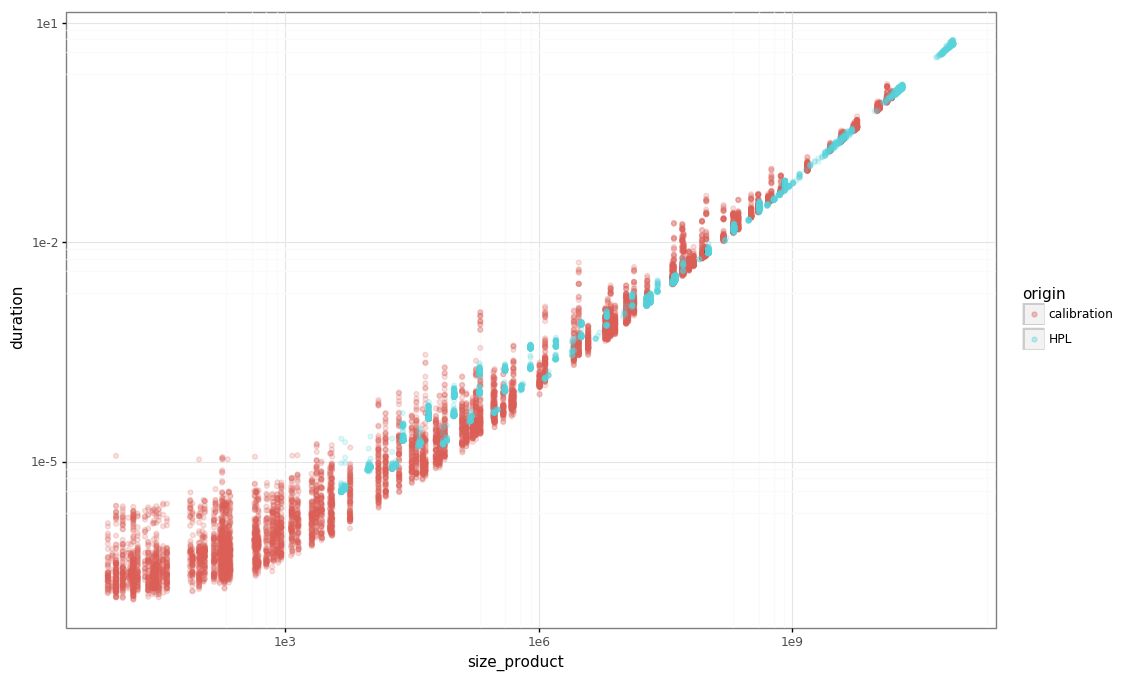

<ggplot: (-9223363307458198861)>

In [4]:
plot = ggplot(aes(x='size_product', y='duration', color='origin')) + scale_x_log10() + scale_y_log10() + theme_bw()
plot + geom_point(df.sample(n=10000), alpha=0.2) + geom_point(hpl_dgemm.sample(n=10000), alpha=0.2)

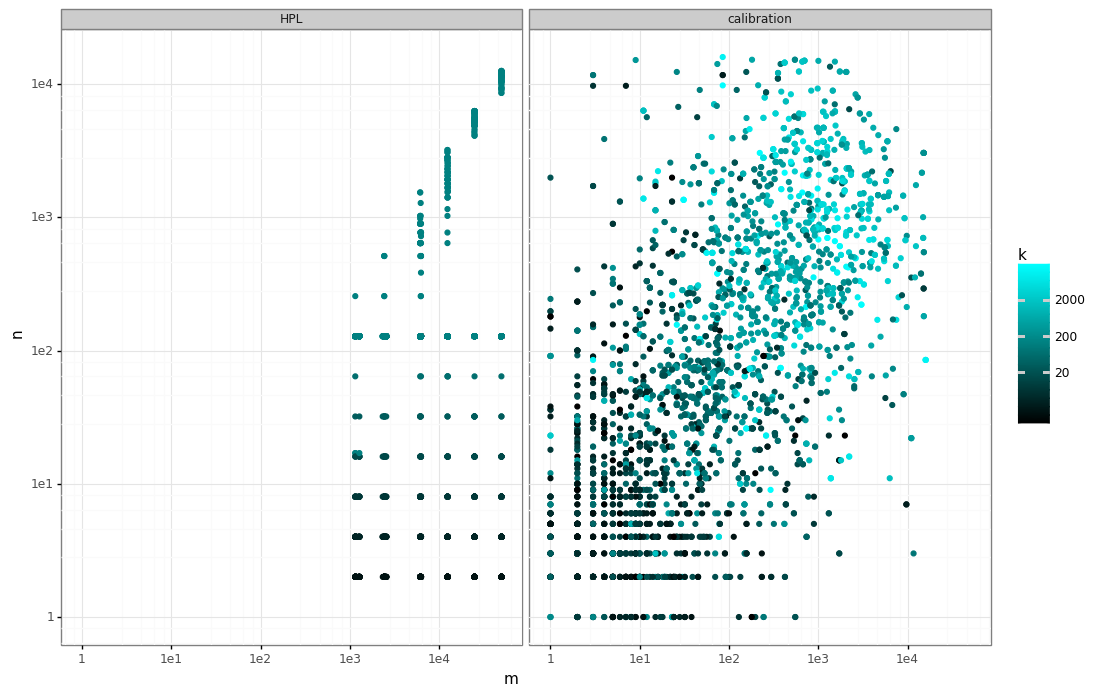

<ggplot: (-9223363307462683918)>


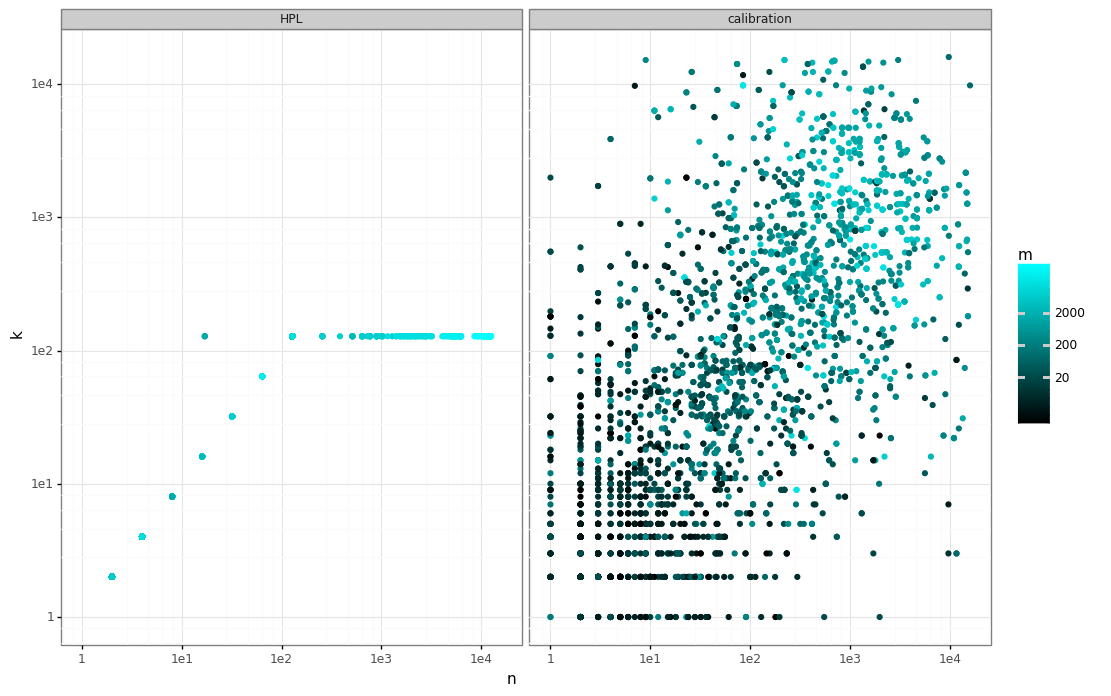

<ggplot: (-9223363307462778066)>


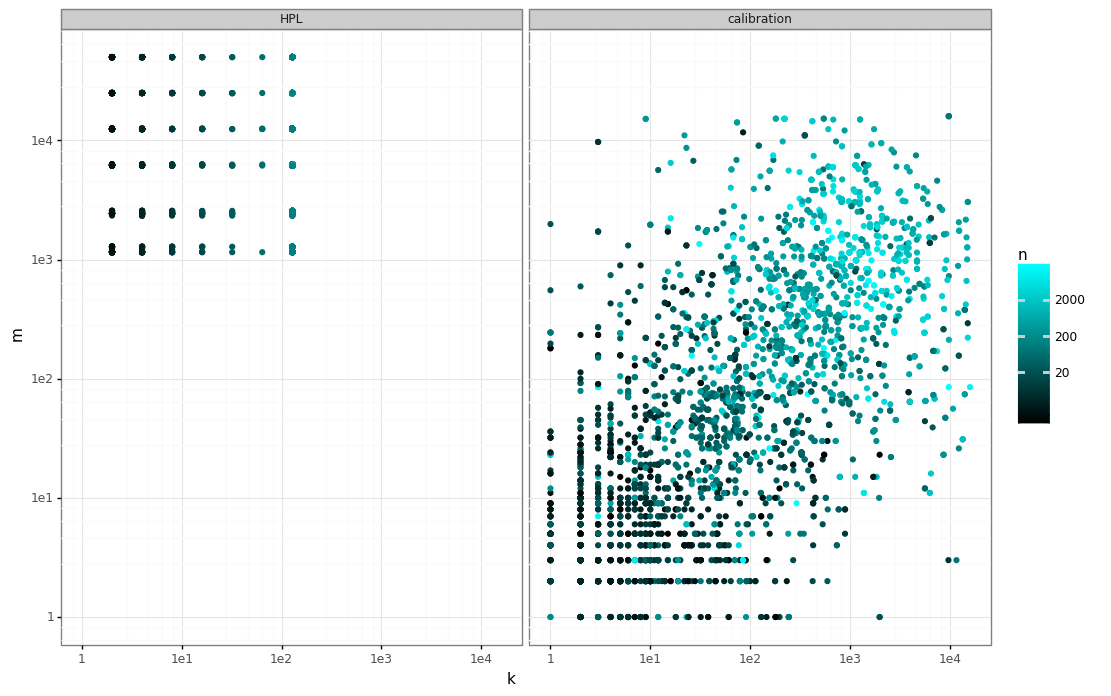

<ggplot: (8729392110491)>


In [5]:
plot = ggplot(pandas.concat([df.sample(n=3000), hpl_dgemm.sample(n=3000)])) + facet_wrap('origin') + theme_bw()
plot = plot + scale_x_log10() + scale_y_log10() + scale_colour_gradient(trans = 'log', breaks=[20, 200, 2000], low='black', high='cyan')
for x, y, z in [['m', 'n', 'k'], ['n', 'k', 'm'], ['k', 'm', 'n']]:
    print(plot + geom_point(aes(x=x, y=y, color=z)))

## Classical regression

In [6]:
from statsmodels.formula.api import ols

reg = ols(formula='duration ~ size_product', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 9.191e+08
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:14:13   Log-Likelihood:             2.1985e+07
No. Observations:             8640000   AIC:                        -4.397e+07
Df Residuals:                 8639998   BIC:                        -4.397e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0008    6.8e-06    122.185      0.000       0.001       0.001
size_product  6.775e-11   2.23e-15   3.03e+04      0.000    6.77e-11    6.78e-11
==============================================================================
Omnibus:                 16128207.219   Durbin-Watson:                   0.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      40773642644.887
Skew:                          14.093   Prob(JB):                         0.00
Kurtosis:                     338.359   Cond. No.                     3.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression on aggregated data

In [7]:
aggr = df.groupby(['m', 'n', 'k'])[['duration', 'size_product']].mean().reset_index()
aggr.head()

,m,n,k,duration,size_product
0,1,1,180,2.481081e-06,180
1,1,2,5,6.346322e-07,10
2,1,2,6,4.035604e-07,12
3,1,2,7,4.281948e-07,14
4,1,2,8,3.131028e-07,16


In [8]:
reg = ols(formula='duration ~ size_product', data=aggr).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.812e+05
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:14:14   Log-Likelihood:                 7048.0
No. Observations:                2669   AIC:                        -1.409e+04
Df Residuals:                    2667   BIC:                        -1.408e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0009      0.000      2.673      0.008       0.000       0.002
size_product  6.774e-11    1.1e-13    617.409      0.000    6.75e-11     6.8e-11
==============================================================================
Omnibus:                     5715.649   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24969055.527
Skew:                          18.494   Prob(JB):                         0.00
Kurtosis:                     475.395   Cond. No.                     3.42e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Polynomial regression with a fixed intercept

In [9]:
aggr['mnk'] = aggr.m * aggr.n * aggr.k
aggr['mn'] = aggr.m * aggr.n
aggr['mk'] = aggr.m * aggr.k
aggr['nk'] = aggr.n * aggr.k

intercept = intercept_duration = aggr[aggr['duration'] < aggr['duration'].quantile(0.005)].duration.mean()
intercept

2.844700396825401e-07

In [10]:
aggr['duration2'] = aggr['duration'] - intercept
reg = ols(formula='duration2 ~ mnk + mn + mk + nk + 0', data=aggr).fit()
params = params_duration = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              duration2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.207e+06
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:14:14   Log-Likelihood:                 12222.
No. Observations:                2669   AIC:                        -2.444e+04
Df Residuals:                    2665   BIC:                        -2.441e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mnk         6.317e-11   2.33e-14   2715.705      0.000    6.31e-11    6.32e-11
mn          1.489e-10   1.05e-11     14.189      0.000    1.28e-10    1.69e-10
mk          2.108e-09   1.05e-11    200.870      0.000    2.09e-09    2.13e-09
nk          3.333e-09   1.05e-11    317.597      0.000    3.31e-09    3.35e-09
==============================================================================
Omnibus:                     1404.728   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           200628.929
Skew:                          -1.457   Prob(JB):                         0.00
Kurtosis:                      45.374   Cond. No.                         828.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

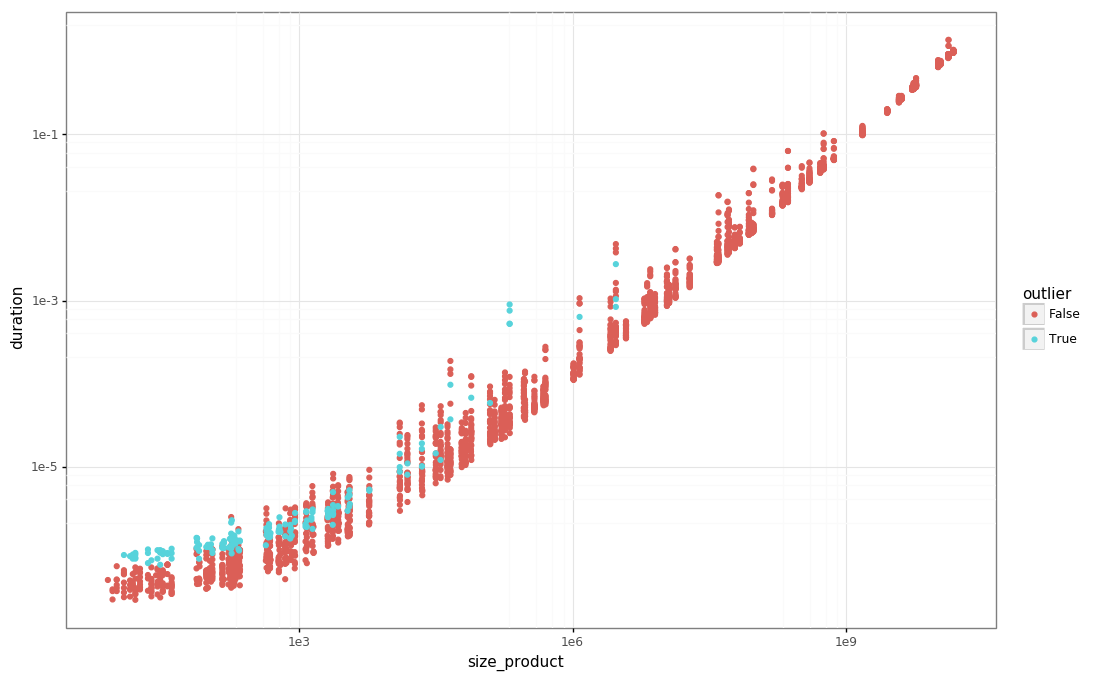

<ggplot: (-9223363307458193166)>

In [11]:
aggr['pred'] = aggr.mnk * params.mnk + aggr.mn * params.mn + aggr.mk * params.mk + aggr.nk * params.nk + intercept
aggr['outlier'] = (aggr['duration'] > 2*aggr['pred']) | (aggr['duration'] < 0.5*aggr['pred'])
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10()

33.16% of "outliers"


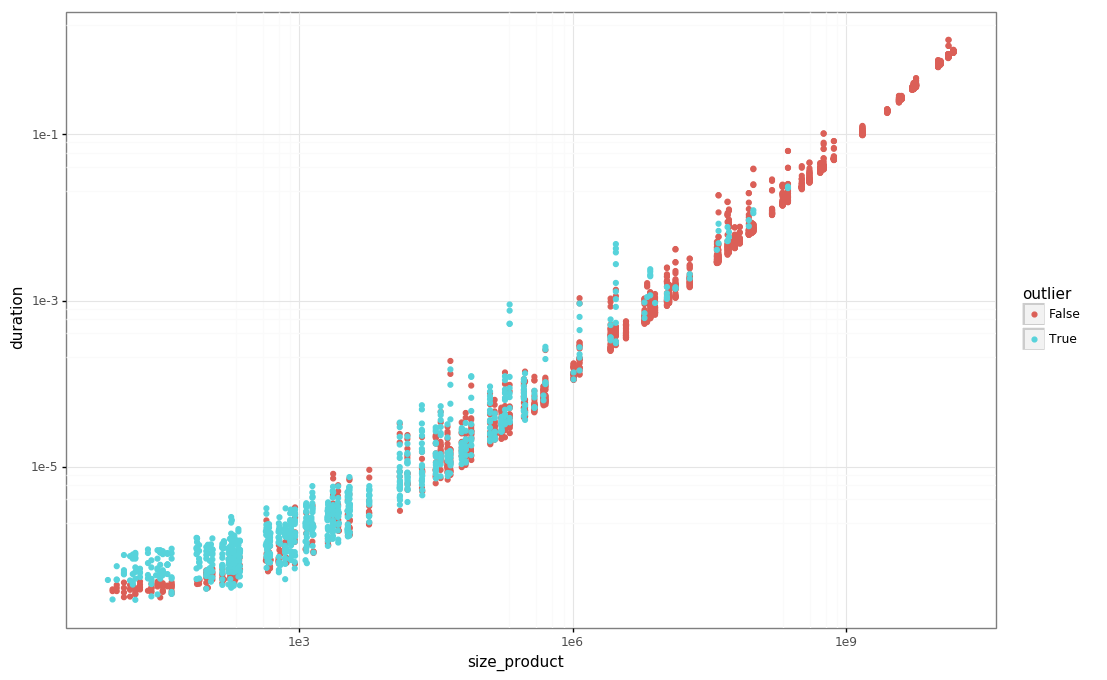

<ggplot: (-9223363307472439061)>

In [12]:
factor = 1.2
aggr['outlier'] = (aggr['duration'] > aggr['pred']*factor) | (aggr['duration'] < aggr['pred']/factor)
print('%.2f%% of "outliers"' % (100*len(aggr[aggr.outlier])/len(aggr)))
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10()

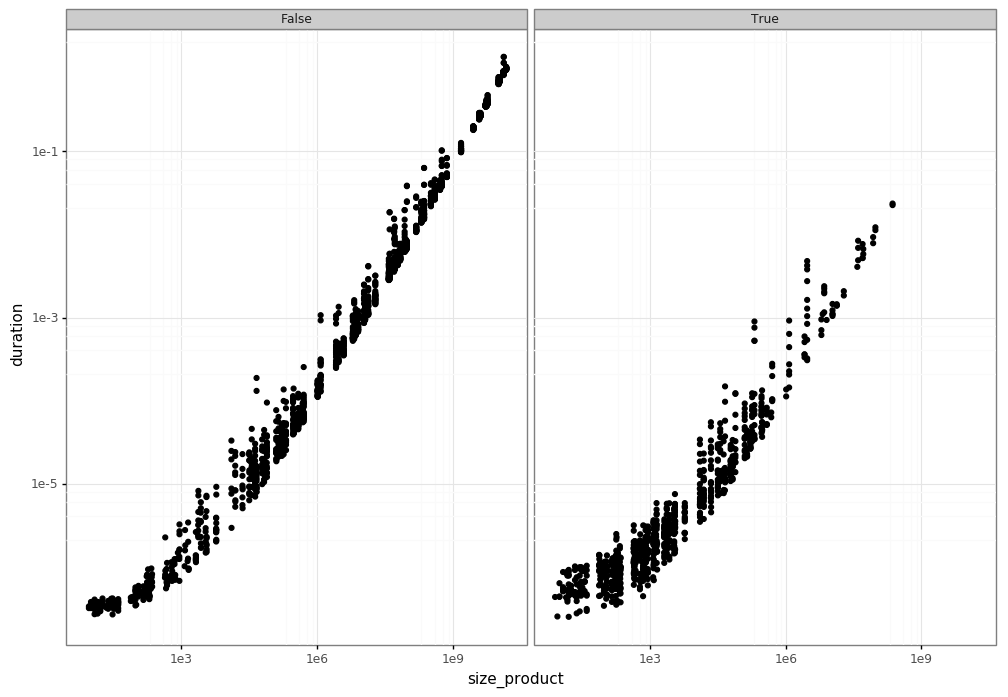

<ggplot: (8729392089804)>

In [13]:
ggplot(aggr) + geom_point(aes(x='size_product', y='duration')) + theme_bw() + scale_x_log10() + scale_y_log10() + facet_wrap('outlier')

Does not seem too bad !

In [14]:
print('real intercept: %e' % intercept)
print(params)

real intercept: 2.844700e-07
mnk    6.317136e-11
mn     1.489053e-10
mk     2.107985e-09
nk     3.332944e-09
dtype: float64


In [15]:
df['mnk'] = df.m * df.n * df.k
df['mn'] = df.m * df.n
df['mk'] = df.m * df.k
df['nk'] = df.n * df.k
df['pred'] = df.mnk * params.mnk + df.mn * params.mn + df.mk * params.mk + df.nk * params.nk + intercept

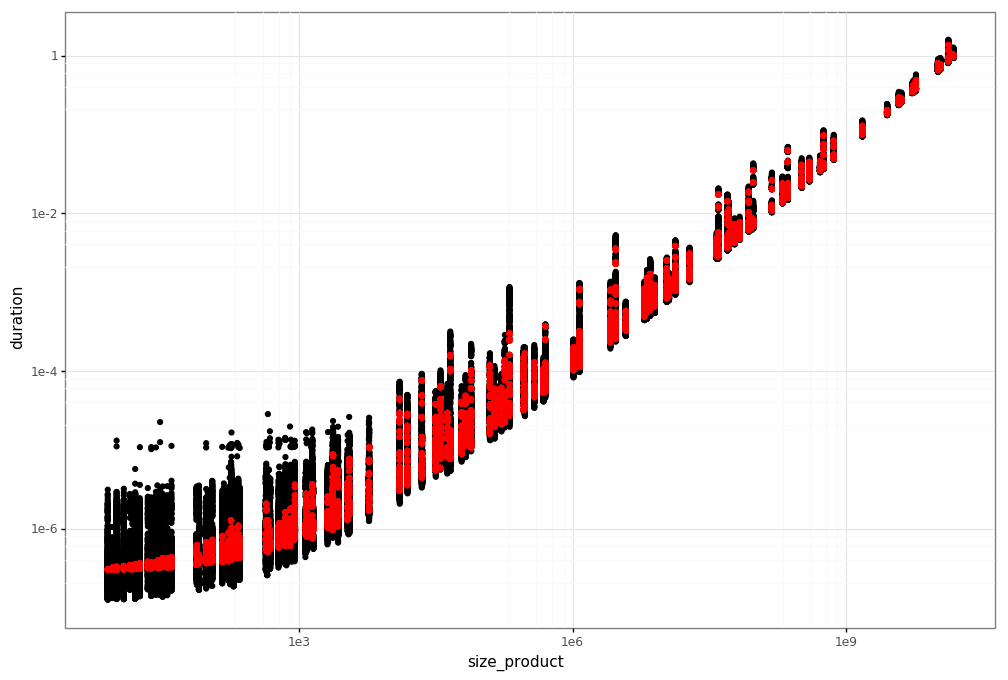

<ggplot: (8729391819798)>

In [16]:
ggplot(df.sample(n=100000)) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred'), color='red', alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10()

## Finding a model for the residuals

In [17]:
df['residual'] = df['duration'] - df['pred']
df['residual'].mean()

-5.6432842160011965e-05

In [18]:
tmp = df.groupby(['m', 'n', 'k'])[['residual']].agg(['mean', 'std'])
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index()
tmp['mnk'] = tmp['m'] * tmp['n'] * tmp['k']
tmp['mn'] = tmp['m'] * tmp['n']
tmp['mk'] = tmp['m'] * tmp['k']
tmp['nk'] = tmp['n'] * tmp['k']
tmp.head()

,m,n,k,mean,std,mnk,mn,mk,nk
0,1,1,180,1.205724e-06,2.158202e-06,180,1,180,180
1,1,2,5,3.053633e-07,8.096932e-07,10,2,5,10
2,1,2,6,6.539127e-08,3.703941e-07,12,2,6,12
3,1,2,7,8.112543e-08,4.232391e-07,14,2,7,14
4,1,2,8,-4.286680e-08,5.663539e-07,16,2,8,16


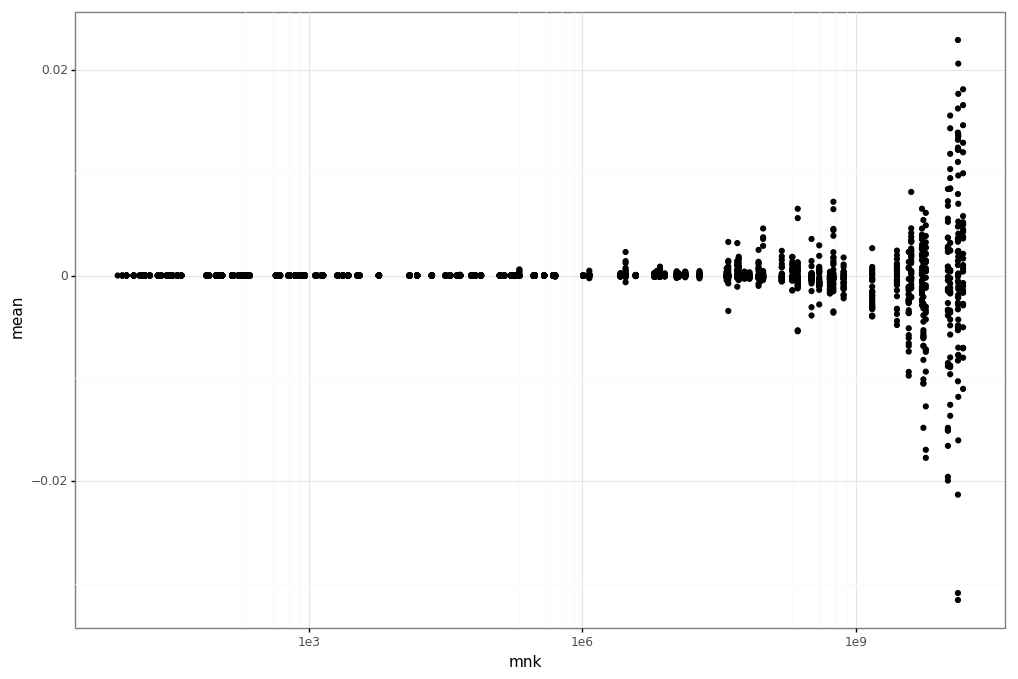

<ggplot: (-9223363307462645886)>

In [19]:
ggplot(tmp, aes(x='mnk', y='mean')) + geom_point() + scale_x_log10() + theme_bw()

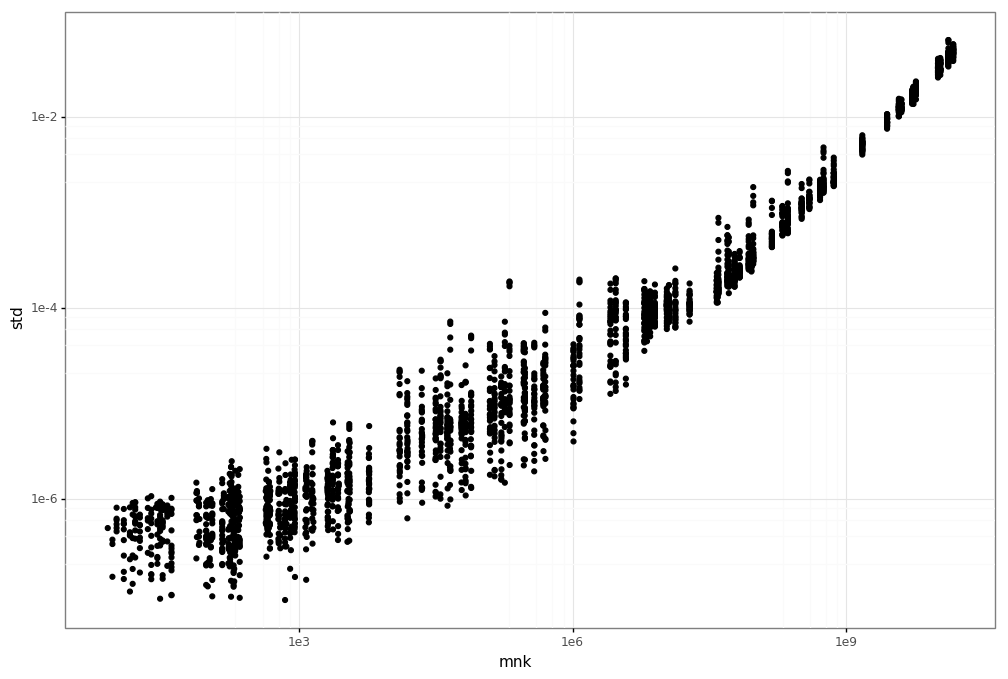

<ggplot: (8729392150329)>

In [20]:
ggplot(tmp, aes(x='mnk', y='std')) + geom_point() + scale_x_log10() + scale_y_log10() + theme_bw()

In [21]:
intercept = tmp[tmp['std'] < tmp['std'].quantile(0.005)]['std'].mean()
intercept

1.0872018065879725e-07

In [22]:
tmp['std2'] = tmp['std'] - intercept
reg = ols(data=tmp, formula='std2 ~ mnk + mn + nk + mk + 0').fit()
params = params_noise = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   std2   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 7.630e+04
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:14:33   Log-Likelihood:                 14742.
No. Observations:                2669   AIC:                        -2.948e+04
Df Residuals:                    2665   BIC:                        -2.945e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mnk         2.977e-12   9.05e-15    329.019      0.000    2.96e-12    2.99e-12
mn          8.366e-12   4.08e-12      2.050      0.040    3.62e-13    1.64e-11
nk          9.931e-11   4.08e-12     24.332      0.000    9.13e-11    1.07e-10
mk          1.529e-10   4.08e-12     37.451      0.000    1.45e-10    1.61e-10
==============================================================================
Omnibus:                      882.028   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78654.897
Skew:                           0.602   Prob(JB):                         0.00
Kurtosis:                      29.567   Cond. No.                         828.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

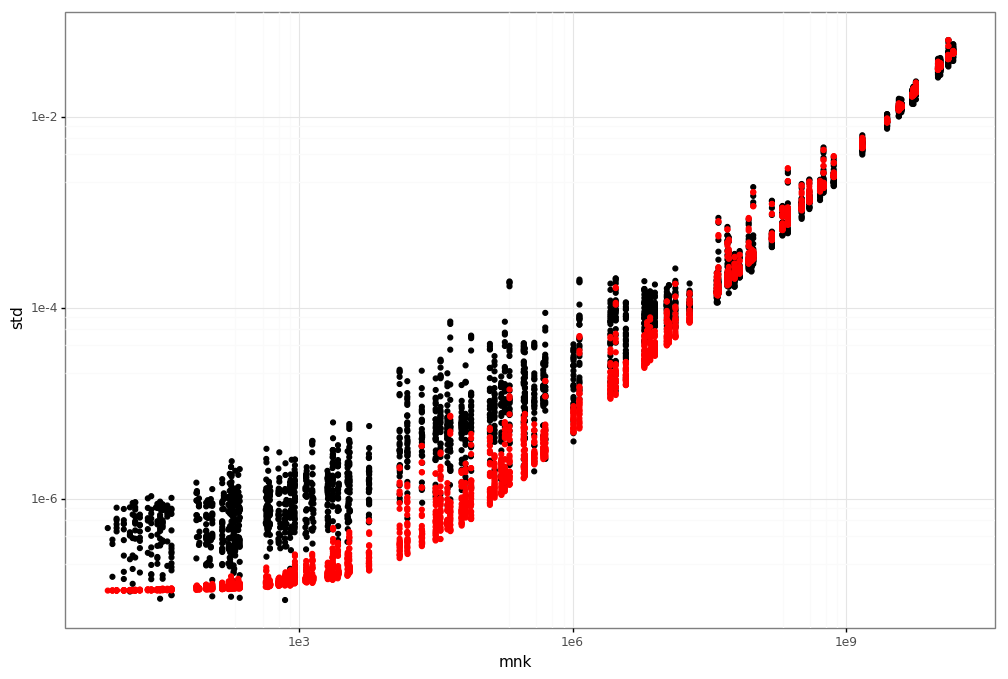

<ggplot: (-9223363307462611042)>

In [23]:
tmp['pred'] = intercept + params.mnk * tmp.mnk + params.mn * tmp.mn + params.mk * tmp.mk + params.nk * tmp.nk
ggplot(tmp, aes(x='mnk', y='std')) + geom_point() + geom_point(aes(x='mnk', y='pred'), color='red') + scale_x_log10() + scale_y_log10() + theme_bw()

In [24]:
import numpy
df['sd_noise'] = intercept + params.mnk * df.mnk + params.mn * df.mn + params.mk * df.mk + params.nk * df.nk
df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
df['noise'] *= df['sigma']
df['noise'] += df['mu']
df['pred_noise'] = df['pred'] + df['noise']

df['reg_line'] = df['mnk'] * params_duration.mnk + intercept_duration

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 8 in image.
  from_inches(height, units), units))
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /tmp/dgemm.pdf
  warn('Filename: {}'.format(filename))


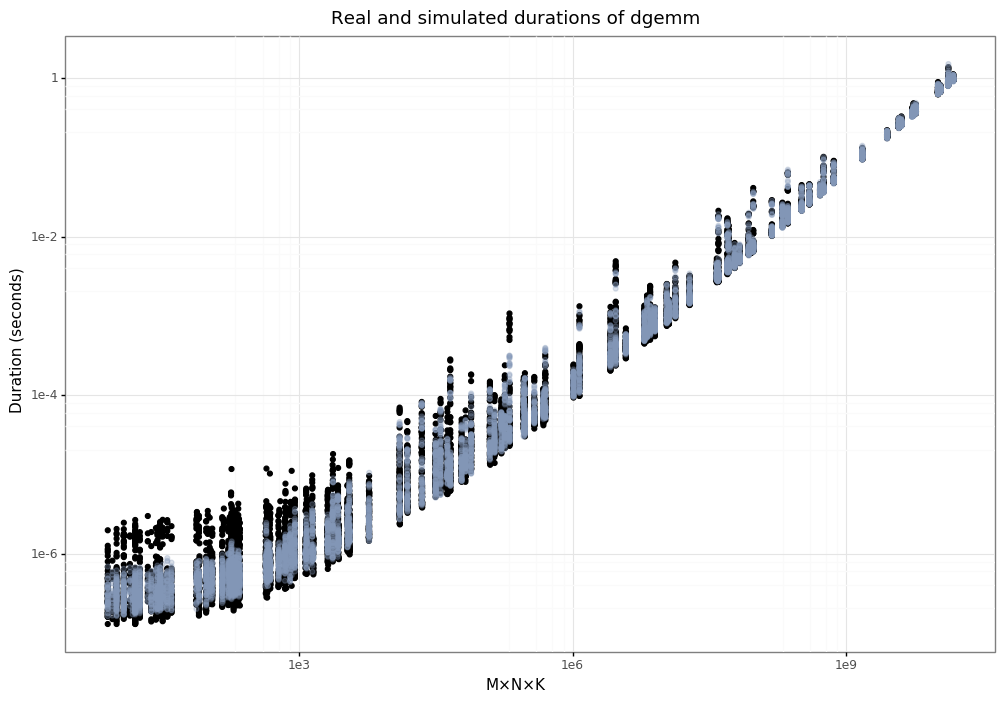

<ggplot: (-9223363307458220088)>

In [25]:
plot = ggplot(df.sample(n=10000)) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='#8599B9', alpha=0.3)
plot = plot + xlab('M×N×K') + ylab('Duration (seconds)') + ggtitle('Real and simulated durations of dgemm') + theme_bw() + scale_x_log10() + scale_y_log10()
plot.save('/tmp/dgemm.pdf')
plot

In [26]:
print(intercept)
params

1.0872018065879725e-07


mnk    2.976703e-12
mn     8.365868e-12
nk     9.931248e-11
mk     1.528598e-10
dtype: float64

## Validation on HPL data

In [27]:
hpl_dgemm['mnk'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k
hpl_dgemm['mn'] = hpl_dgemm.m * hpl_dgemm.n
hpl_dgemm['mk'] = hpl_dgemm.m * hpl_dgemm.k
hpl_dgemm['nk'] = hpl_dgemm.n * hpl_dgemm.k
hpl_dgemm['pred'] = hpl_dgemm.mnk * params_duration.mnk + hpl_dgemm.mn * params_duration.mn +\
                    hpl_dgemm.mk * params_duration.mk + hpl_dgemm.nk * params_duration.nk + intercept

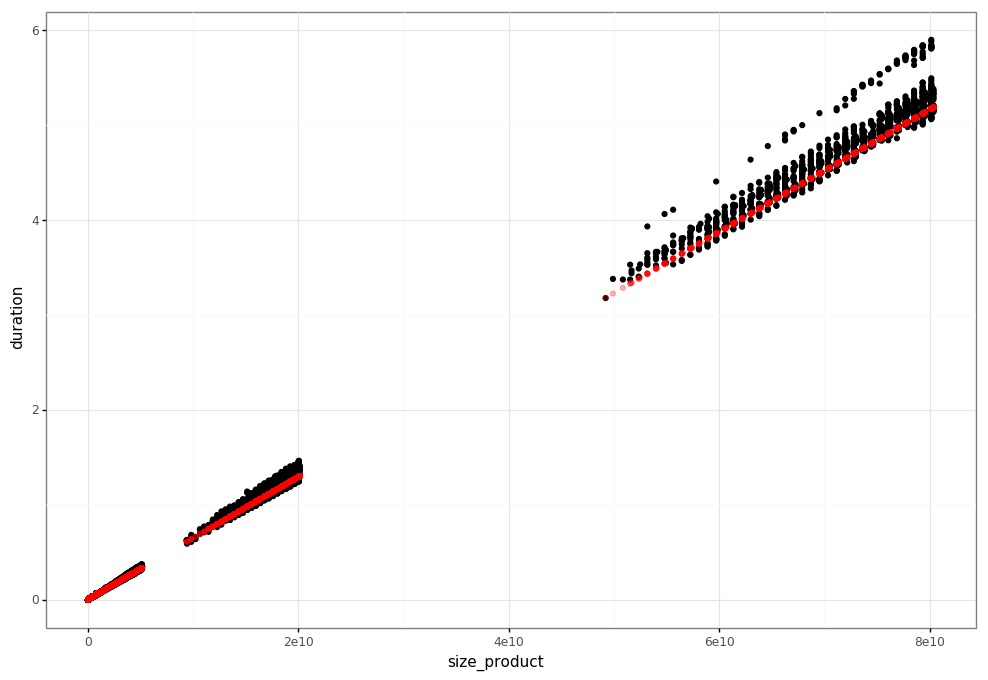

<ggplot: (-9223363307458246852)>


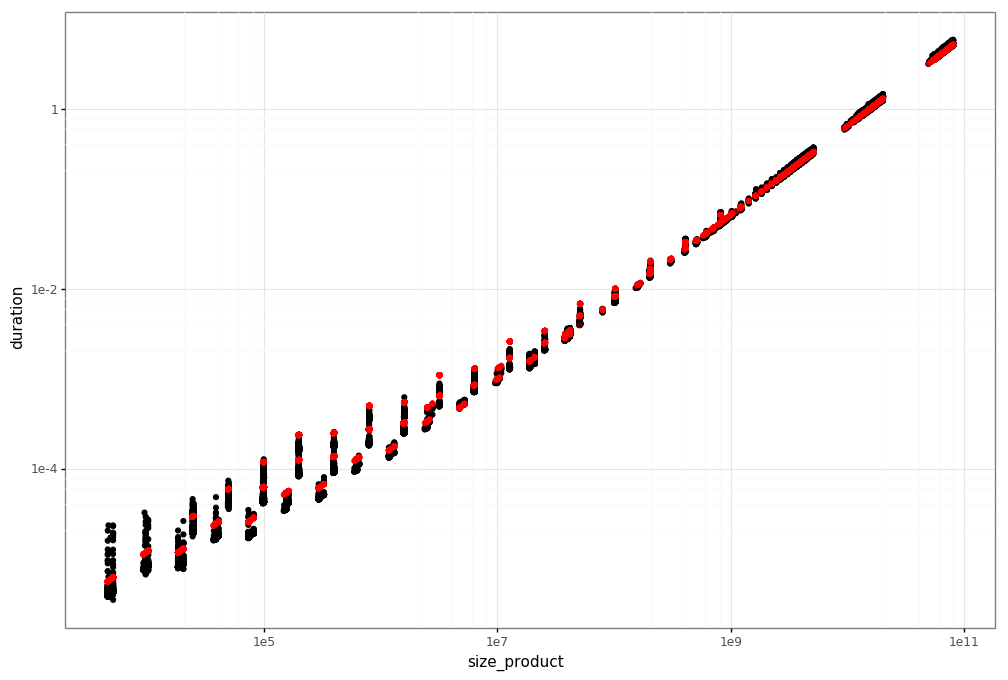

<ggplot: (-9223363307462769755)>


In [28]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

For the record, this is how the half-normal is implemented in HPL:
```c
double random_halfnormal_shifted(double exp, double std) {
    // Here, exp and std are the desired expectation and standard deviation.
    // We compute the corresponding mu and sigma parameters for the normal distribution.
    double mu, sigma;
    sigma = std/sqrt(1-2/M_PI);
    mu = exp - sigma*sqrt(2/M_PI);
    double x = random_halfnormal();
    return x*sigma + mu;
}
```

In [29]:
hpl_dgemm['sd_noise'] = intercept + params_noise.mnk * hpl_dgemm.mnk + params_noise.mn * hpl_dgemm.mn + params_noise.mk * hpl_dgemm.mk + params_noise.nk * hpl_dgemm.nk
hpl_dgemm['sigma'] = hpl_dgemm['sd_noise']/numpy.sqrt(1-2/numpy.pi)
hpl_dgemm['mu'] = -hpl_dgemm['sigma']*numpy.sqrt(2/numpy.pi)
hpl_dgemm['noise'] = numpy.abs(numpy.random.normal(0, 1, len(hpl_dgemm)))
hpl_dgemm['noise'] *= hpl_dgemm['sigma']
hpl_dgemm['noise'] += hpl_dgemm['mu']

hpl_dgemm['pred_noise'] = hpl_dgemm['pred'] + hpl_dgemm['noise']

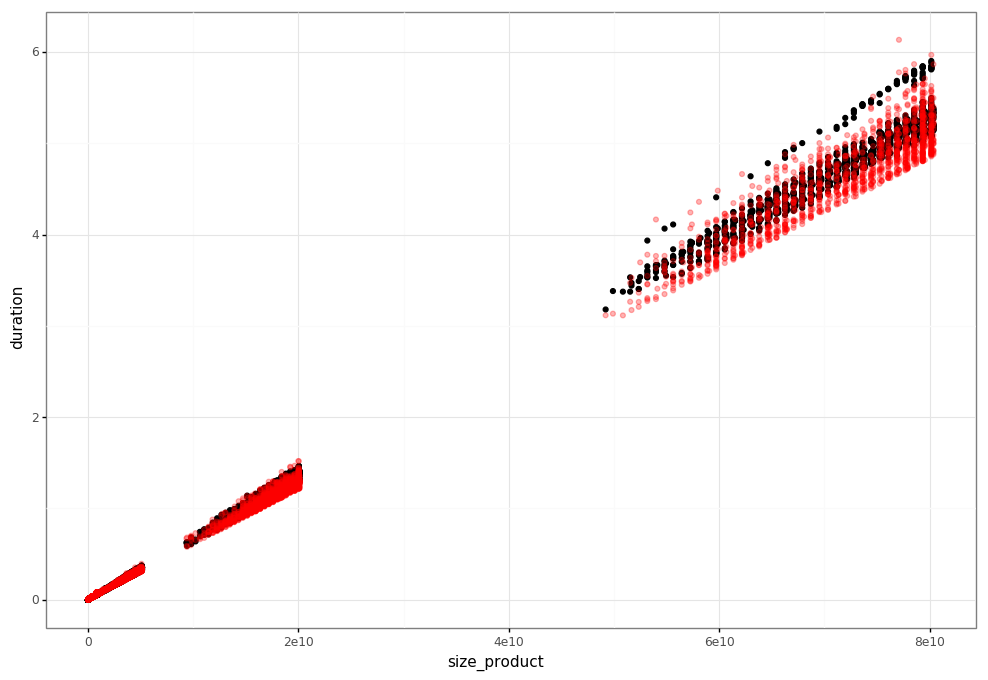

<ggplot: (8729392019804)>


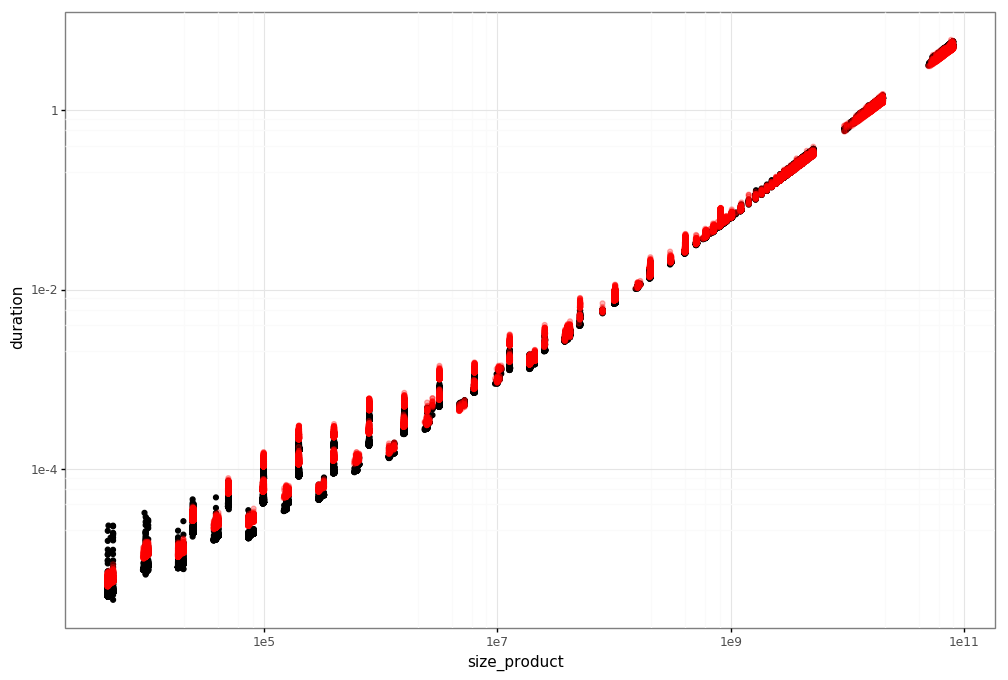

<ggplot: (8729392029013)>


In [30]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())